In [49]:
import seaborn as sns
import pandas as pd

In [50]:
# Read the JSONL file and load the data into a DataFrame using pandas
df = pd.read_json('cp_shardq.jsonl', lines=True)
df['qo_factor'] = (df['kv_len'] / 1024).astype(int)

In [51]:
# Group the DataFrame by the specified columns and calculate the mean and standard deviation of 'median_compute_time'
aggregated_df = df.groupby(['batch_size', 'qo_factor', 'num_qo_heads', 'num_kv_heads', 'head_dim', 'cp_degree']).agg(
    avg_median_compute_time=('median_compute_time', 'mean'),
    std_median_compute_time=('median_compute_time', 'std'),
    # max_median_compute_time=('median_compute_time', 'max'),
    # min_median_compute_time=('median_compute_time', 'min')
).reset_index()

aggregated_df["value_str"] = aggregated_df.apply(
    lambda row: f"{row['avg_median_compute_time']:.2f} ± {row['std_median_compute_time']:.2f}",
    axis=1
)

# Display the aggregated DataFrame
aggregated_df


,batch_size,qo_factor,num_qo_heads,num_kv_heads,head_dim,cp_degree,avg_median_compute_time,std_median_compute_time,value_str
0,1,8,32,8,128,1,4.006552,0.001595,4.01 ± 0.00
1,1,16,32,8,128,1,14.322752,0.994249,14.32 ± 0.99
2,1,16,32,8,128,8,2.662462,0.031470,2.66 ± 0.03
3,1,32,32,8,128,1,56.952279,0.069252,56.95 ± 0.07
4,1,32,32,8,128,8,8.168694,0.276056,8.17 ± 0.28
5,1,64,32,8,128,1,214.530926,0.029979,214.53 ± 0.03
6,1,64,32,8,128,8,29.609258,1.352225,29.61 ± 1.35
7,1,128,32,8,128,1,854.601181,0.444898,854.60 ± 0.44
8,1,128,32,8,128,8,108.328822,0.016575,108.33 ± 0.02
9,1,256,32,8,128,1,3446.281006,NaN,3446.28 ± nan


In [52]:
# filter aggregate_df to only include rows where cp_degree is 8
aggregated_df_filtered_cp = aggregated_df[aggregated_df['cp_degree'] == 8]

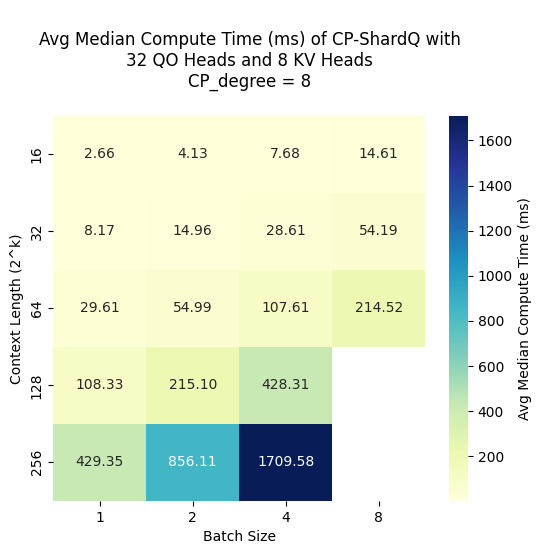

In [65]:
import matplotlib.pyplot as plt

# Create a heatmap with seaborn
plt.figure(figsize=(6, 5))
heatmap_data = aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="avg_median_compute_time"
)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Median Compute Time (ms)'})
num_qo_heads = aggregated_df_filtered_cp["num_qo_heads"].unique()[0]
num_kv_heads = aggregated_df_filtered_cp["num_kv_heads"].unique()[0]
cp_degree = aggregated_df_filtered_cp["cp_degree"].unique()[0]
plt.title(
    f'''
    Avg Median Compute Time (ms) of CP-ShardQ with
    {num_qo_heads} QO Heads and {num_kv_heads} KV Heads
    CP_degree = {cp_degree}
    ''')
plt.xlabel('Batch Size')
plt.ylabel('Context Length (2^k)')
plt.show()


In [54]:
aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="value_str"
)

batch_size,1,2,4,8
qo_factor,,,,
16,2.66 ± 0.03,4.13 ± 0.14,7.68 ± 0.29,14.61 ± 0.63
32,8.17 ± 0.28,14.96 ± 0.69,28.61 ± 1.30,54.19 ± 0.52
64,29.61 ± 1.35,54.99 ± 0.88,107.61 ± 0.03,214.52 ± 0.00
128,108.33 ± 0.02,215.10 ± 0.02,428.31 ± 0.08,NaN
256,429.35 ± 0.18,856.11 ± 0.12,1709.58 ± 0.23,NaN
